Baseado em: https://github.com/rcmalli/keras-squeezenet

In [1]:
%matplotlib inline

### Imports e funções

In [2]:
import os
import numpy as np
from random import sample, seed
seed(42)
np.random.seed(42)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15,15) # Make the figures a bit bigger

# Keras imports
from keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
from keras.utils import get_file

#read all images (jpg, png) in imgDirPath and resize to 227x227
def readImagesFromDir(imgDirPath):
    fileNames = os.listdir(imgDirPath)
    imagePaths = [os.path.join(imgDirPath,img) for img in fileNames if img[-3:] in ['jpg', 'png']]
    imageList = [load_img(img, target_size=(227, 227)) for img in imagePaths]
    imageList = [img_to_array(img) for img in imageList]
    return imageList, fileNames

#plot the imgList
def plotImages(imgList):
    for i in range(len(imgList)):
        plotImage(imgList[i])
        
        
def plotImage(img):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)

    ax.imshow(np.uint8(img), interpolation='nearest')
    plt.show()

Using TensorFlow backend.


# Módulo Fire
<img src="./books_images/fire.png" width=30% height=30%>

In [3]:
sq1x1 = "squeeze1x1"
exp1x1 = "expand1x1"
exp3x3 = "expand3x3"
relu = "relu_"

# Modular function for Fire Node
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + sq1x1)(x)
    x = Activation('relu', name=s_id + relu + sq1x1)(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + exp1x1)(x)
    left = Activation('relu', name=s_id + relu + exp1x1)(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + exp3x3)(x)
    right = Activation('relu', name=s_id + relu + exp3x3)(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

# SqueezeNet
<img src="./books_images/squeezenet.png">

In [4]:
def SqueezeNet(input_shape=None, weights_path=None, classes=1000):
    """Instantiates the SqueezeNet architecture.
    """
    img_input = Input(shape=input_shape)

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(img_input)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)
    
    x = Dropout(0.5, name='drop9')(x)

    x = Convolution2D(classes, (1, 1), padding='valid', name='conv10')(x)
    x = Activation('relu', name='relu_conv10')(x)
    x = GlobalAveragePooling2D()(x)
    x = Activation('softmax', name='loss')(x)

    model = Model(img_input, x, name='squeezenet')
    
    if weights_path != None:
        model.load_weights(weights_path)
    
    return model

Após definir a arquitetura, podemos criar nosso modelo passando o tamanho das imagens de entrada e um possível arquivo com os pesos treinados para o modelo. No nosso caso, usaremos os pesos para o modelo treinado usando a biblioteca [ImageNet](http://www.image-net.org/). O arquivo está disponível no link abaixo:

https://github.com/rcmalli/keras-squeezenet/releases/download/v1.0/squeezenet_weights_tf_dim_ordering_tf_kernels.h5

In [5]:
squeezeNetModel = SqueezeNet((227,227,3), "squeezenet_weights_tf_dim_ordering_tf_kernels.h5")
print(squeezeNetModel.summary())

Model: "squeezenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 227, 227, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 113, 113, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
relu_conv1 (Activation)         (None, 113, 113, 64) 0           conv1[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 56, 56, 64)   0           relu_conv1[0][0]                 
_________________________________________________________________________________________

### Explicações e Avaliação

ImageNet é esforço de pesquisa ainda em evolução para criar um dataset de imagens acessível para pesquisadores poderem testar suas pesquisas. Atualmente ela mais de 14 milhões de imagens divididas em 21841 classes. A arquitetura utilizada aqui foi treinada sobre a [ImageNet Kraggle Competition](https://www.kaggle.com/c/imagenet-object-localization-challenge), que continha um subset da ImageNet com 150.000 figuras e 1000 classes distintas.

No exemplo desse notebook, baixamos algumas imagens da ImageNet original e vamos avaliar como nosso modelo pré-treinado se sai para esse subset.

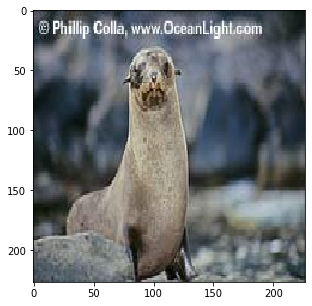

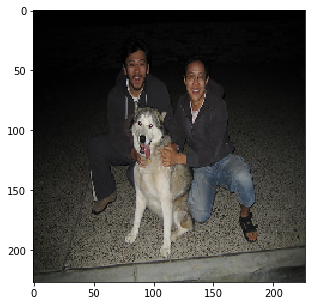

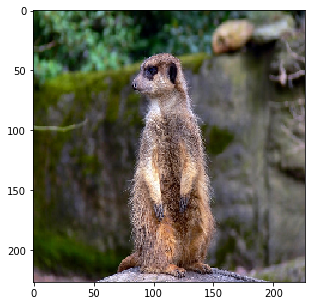

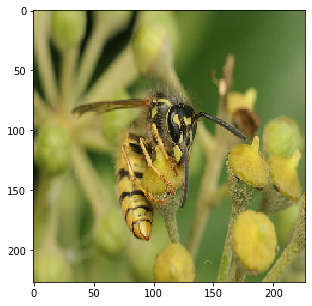

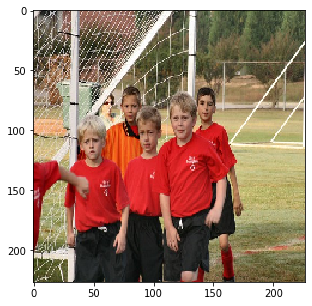

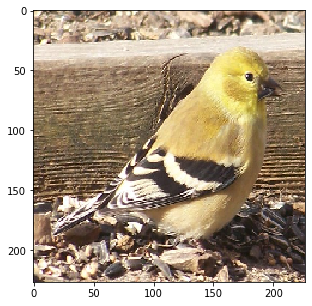

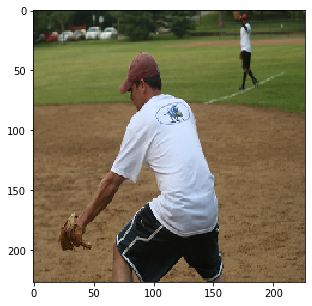

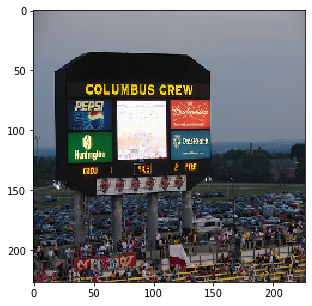

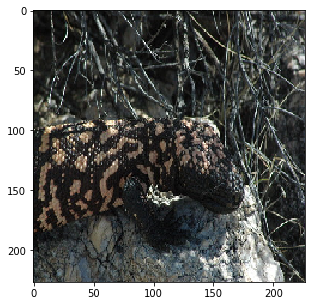

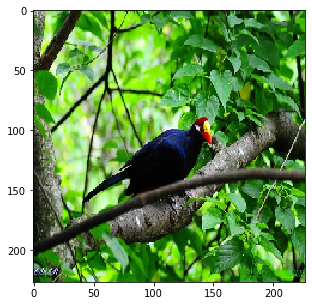

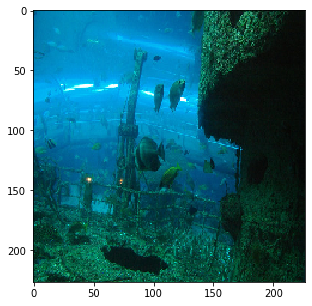

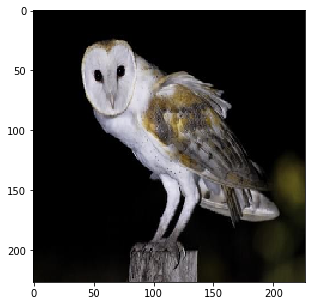

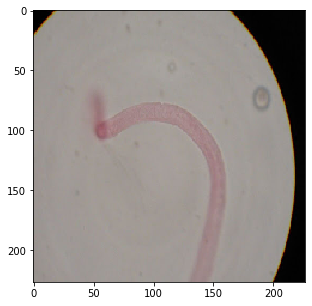

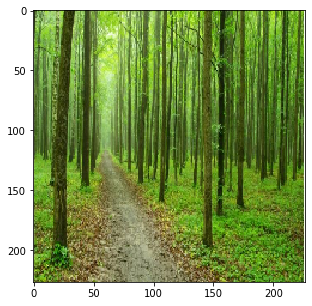

In [6]:
imgList, fileNames = readImagesFromDir('images')
plotImages(imgList)

### Predizendo as imagens

In [7]:
# prepare the image for ResNet50
processed_images = np.array([preprocess_input(img.copy()) for img in imgList])

# get the predicted probabilities for each class
predictions = squeezeNetModel.predict(processed_images, verbose=0)

print("Shape of predictions --> ", predictions.shape)
print("Prediction of the first image:\n", predictions[0])

Shape of predictions -->  (14, 1000)
Prediction of the first image:
 [7.56820242e-08 1.26464803e-08 1.02698792e-07 1.22328359e-07
 9.02571992e-06 4.46363038e-06 1.18122415e-07 3.72046202e-06
 2.62091926e-04 1.09570706e-07 5.59339314e-05 1.93972915e-06
 3.57232102e-06 3.59146213e-07 5.80248738e-08 5.30332136e-06
 2.81424064e-07 2.22273266e-05 5.96845041e-07 4.96507155e-08
 1.57850377e-06 4.74105855e-06 7.99640929e-07 9.20171715e-06
 1.26987405e-04 2.68679550e-08 2.41849079e-06 5.82653108e-08
 5.15943164e-08 1.91986032e-06 7.30090790e-07 1.20446558e-07
 2.06863388e-05 3.99771519e-03 6.69795275e-03 2.74131817e-05
 2.21161172e-04 5.28618375e-06 1.25126289e-05 1.19663882e-05
 7.08226722e-08 1.32145897e-06 2.25173949e-06 1.62063243e-05
 7.62278660e-07 7.58440535e-07 3.04463690e-08 9.64751621e-07
 4.54227964e-04 7.90846144e-08 5.94754361e-08 2.31980879e-09
 3.87768305e-05 9.80598270e-06 3.67892731e-04 1.36131328e-08
 6.80235316e-05 1.11156614e-05 1.03577302e-04 3.39297515e-07
 8.10403162e-06 

### Avaliando os resultados

In [ ]:
# Convert the probabilities to class labels
# We will get top 5 predictions which is the default
imagePredictions = decode_predictions(predictions)
i = 0
for pred in imagePredictions:
    plotImage(imgList[i])
    for possibleClass in pred:
        print(possibleClass[1], possibleClass[2])
    print("\n")
    i+=1